In [1]:
# Plots for section 5.4 (hydrogen intersection with other sectors)

In [2]:
# TODO

## Imports

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, \
    capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, \
    generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO
from utils import generation_links_bus

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, c_tags
from utils import resistive_heater, gas_boiler, heat_pump,water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s, c_h2_gen, c_h2_con

# general variables
font1 = {'fontname': 'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/5.4_hydrogen_whyh2'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger",
                  "solar thermal"]
markers = ["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

# new indices: cut off Fuel cell and SMR completely and SMR CC for exp
c_h2_gen_stst = ['H2 Electrolysis', 'SMR CC']
c_h2_gen_exp = ['H2 Electrolysis']
c_h2_gen = ['H2 Electrolysis', 'SMR CC']
c_h2_con = ['H2 liquefaction', 'Sabatier', 'Fischer-Tropsch']

In [4]:
# Network imports
stst = pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp = pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
# stst and exp dataframes
# spatial
df_stst_ons = pd.read_pickle("../data/processed/df_stst_ons.pkl")
df_stst_off = pd.read_pickle("../data/processed/df_stst_off.pkl")
df_exp_ons = pd.read_pickle("../data/processed/df_exp_ons.pkl")
df_exp_off = pd.read_pickle("../data/processed/df_exp_off.pkl")

# temporal
df_stst_ts = pd.read_pickle("../data/processed/df_stst_ts.pkl")
df_exp_ts = pd.read_pickle("../data/processed/df_exp_ts.pkl")

In [6]:
# Notebook Functions


In [7]:
#assert 0

## Balances

In [8]:
# all buses
stst.buses.carrier.unique()
# Interesting: gas, H2, biogas, solid biomass, solid biomass for industry, gas for industry, H2 liquid, oil,

array(['AC', 'co2', 'co2 stored', 'gas', 'H2', 'battery', 'Li ion',
       'residential rural heat', 'residential rural water tanks',
       'services rural heat', 'services rural water tanks',
       'residential urban decentral heat',
       'residential urban decentral water tanks',
       'services urban decentral heat',
       'services urban decentral water tanks', 'urban central heat',
       'urban central water tanks', 'biogas', 'solid biomass',
       'solid biomass for industry', 'gas for industry', 'H2 liquid',
       'oil', 'process emissions', 'low voltage', 'home battery'],
      dtype=object)

### all heat

In [9]:
stst.buses.carrier.unique()[pd.Index(stst.buses.carrier.unique()).str.contains("heat")].tolist()

['residential rural heat',
 'services rural heat',
 'residential urban decentral heat',
 'services urban decentral heat',
 'urban central heat']

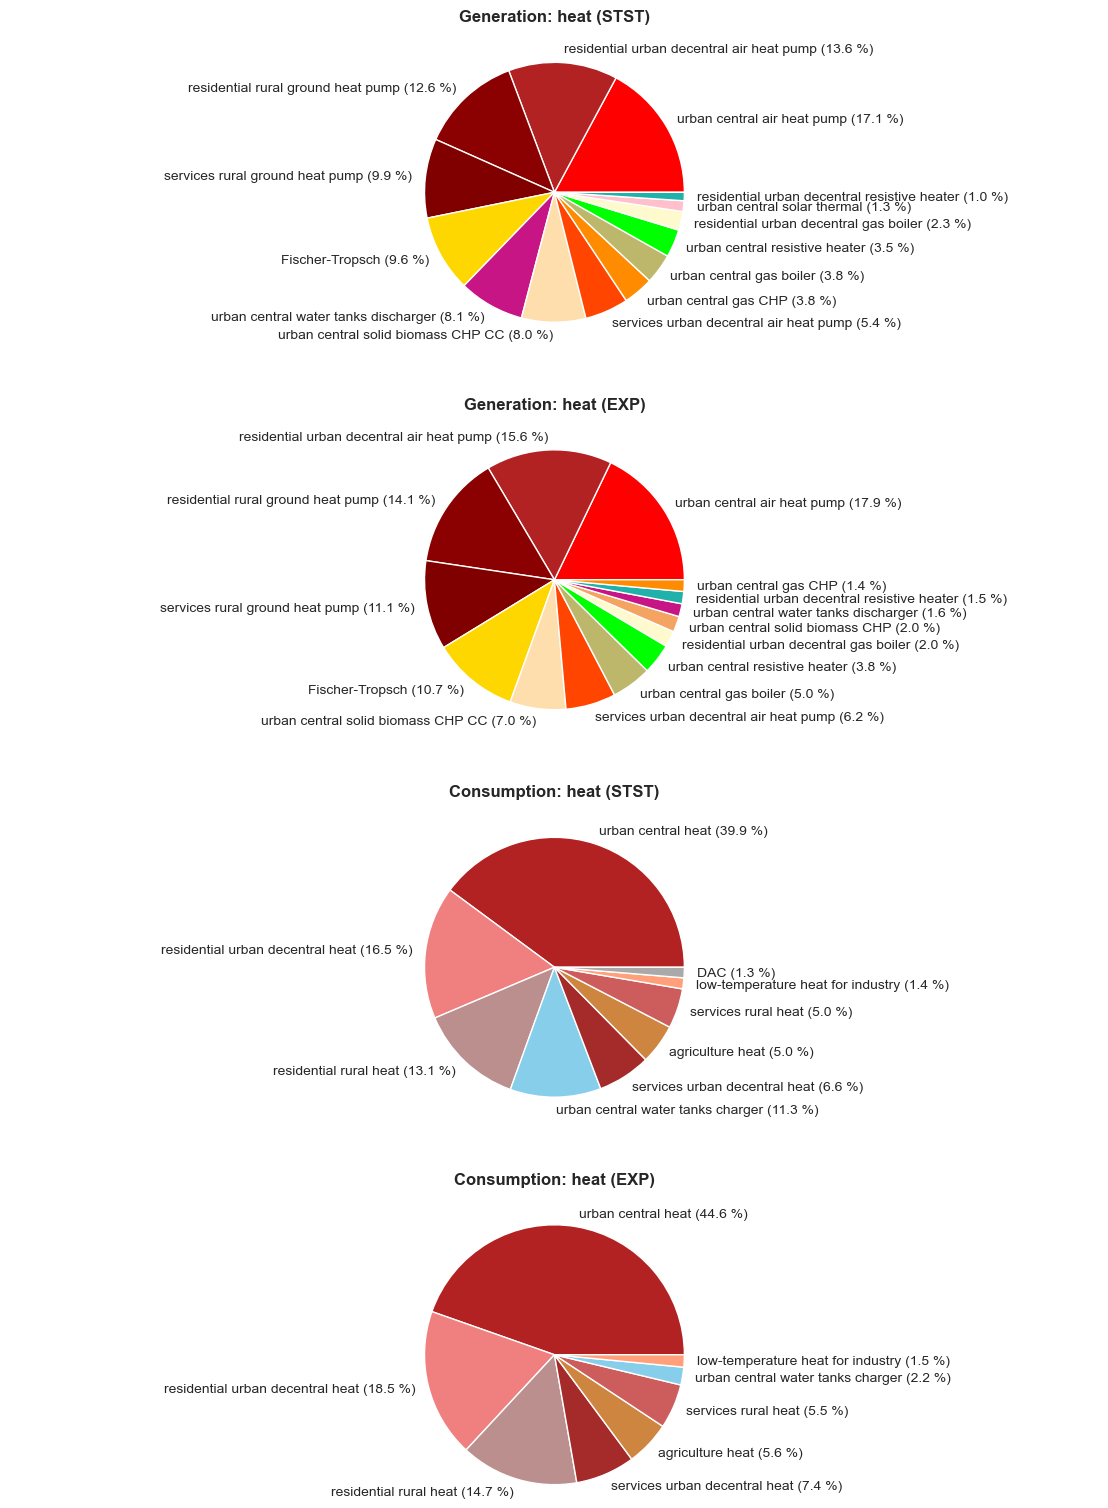

In [10]:
# generation and consumption (all heat)

carriers = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 4*4))

for n in [stst, exp]:

    nb = nodal_balance(n, carrier=carriers, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0]
        ax_con=axs[2]
        title_gen=f"Generation: heat (STST)"
        title_con=f"Consumption: heat (STST)"

    elif n==exp:
        ax_gen=axs[1]
        ax_con=axs[3]
        title_gen=f"Generation: heat (EXP)"
        title_con=f"Consumption: heat (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=4)
#plt.close()
plt.show()

fig.savefig(f"{PLOT_DIR}/heat_gen_con.png")

In [11]:
# Overall heat generation

model = "EXP"

if model == "STST":
    n = stst

elif model == "EXP":
    n = exp

carrier = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)

nb[nb > 0].sum().sum() / 1e3

# STST: 3818 TWh
# EXP: 3407 TWh

3407.0324946381565

### urban central heat

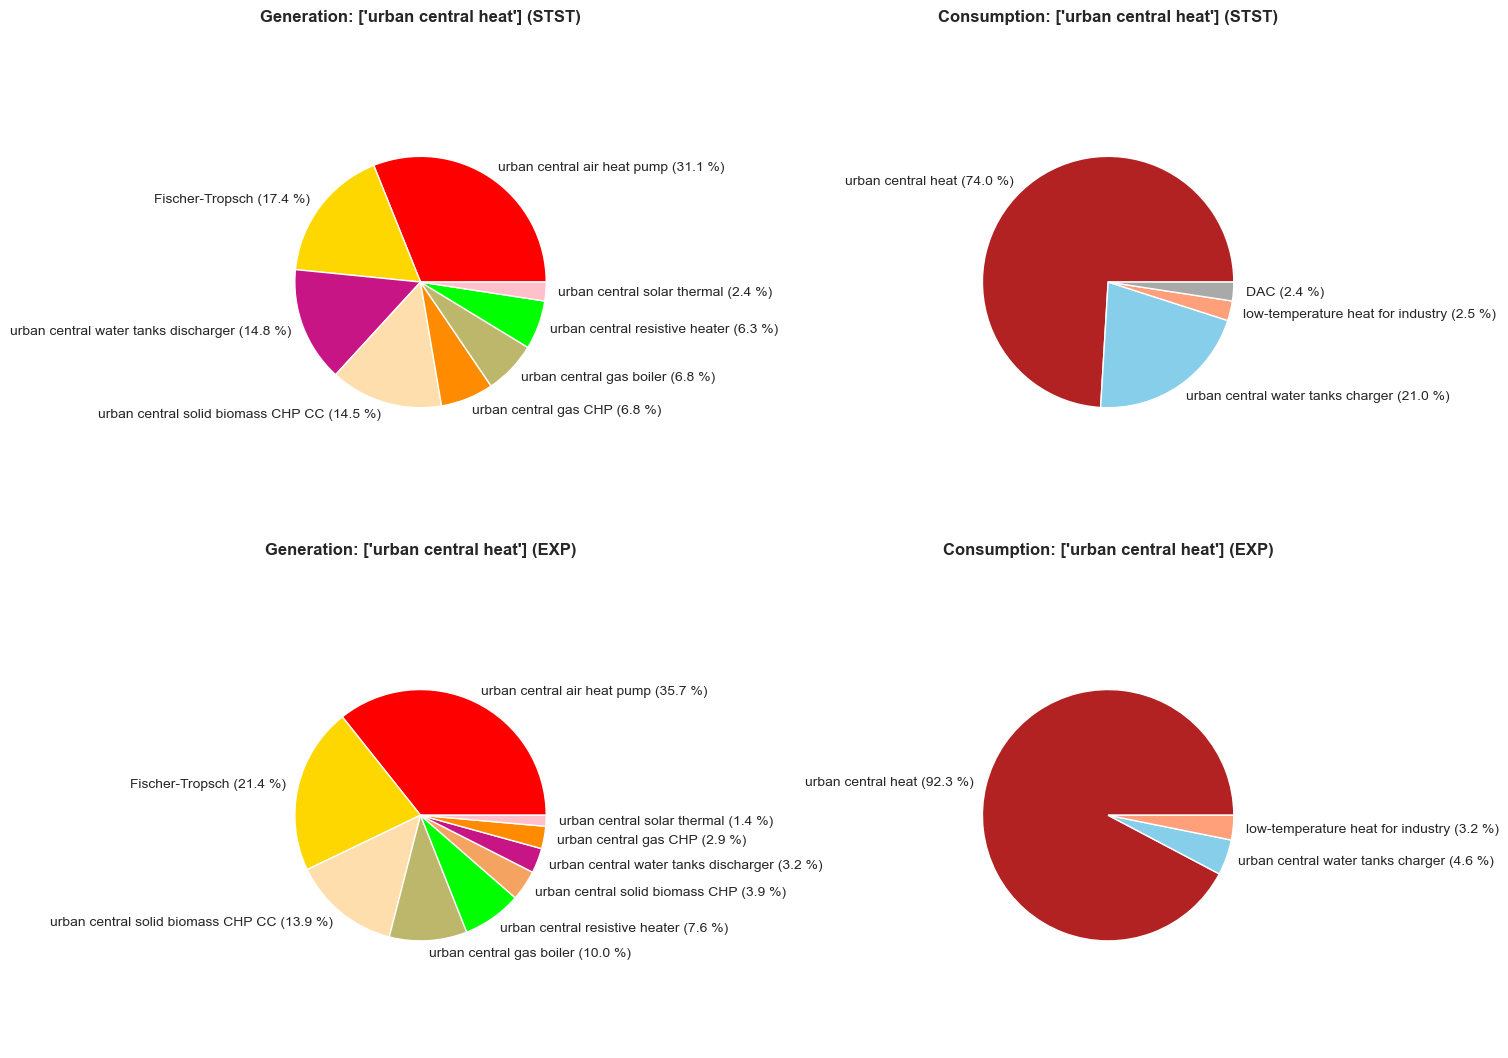

In [12]:
# generation and consumption (urban central heat)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

# Fischer Tropsch nebenprdukt Heat

### oil

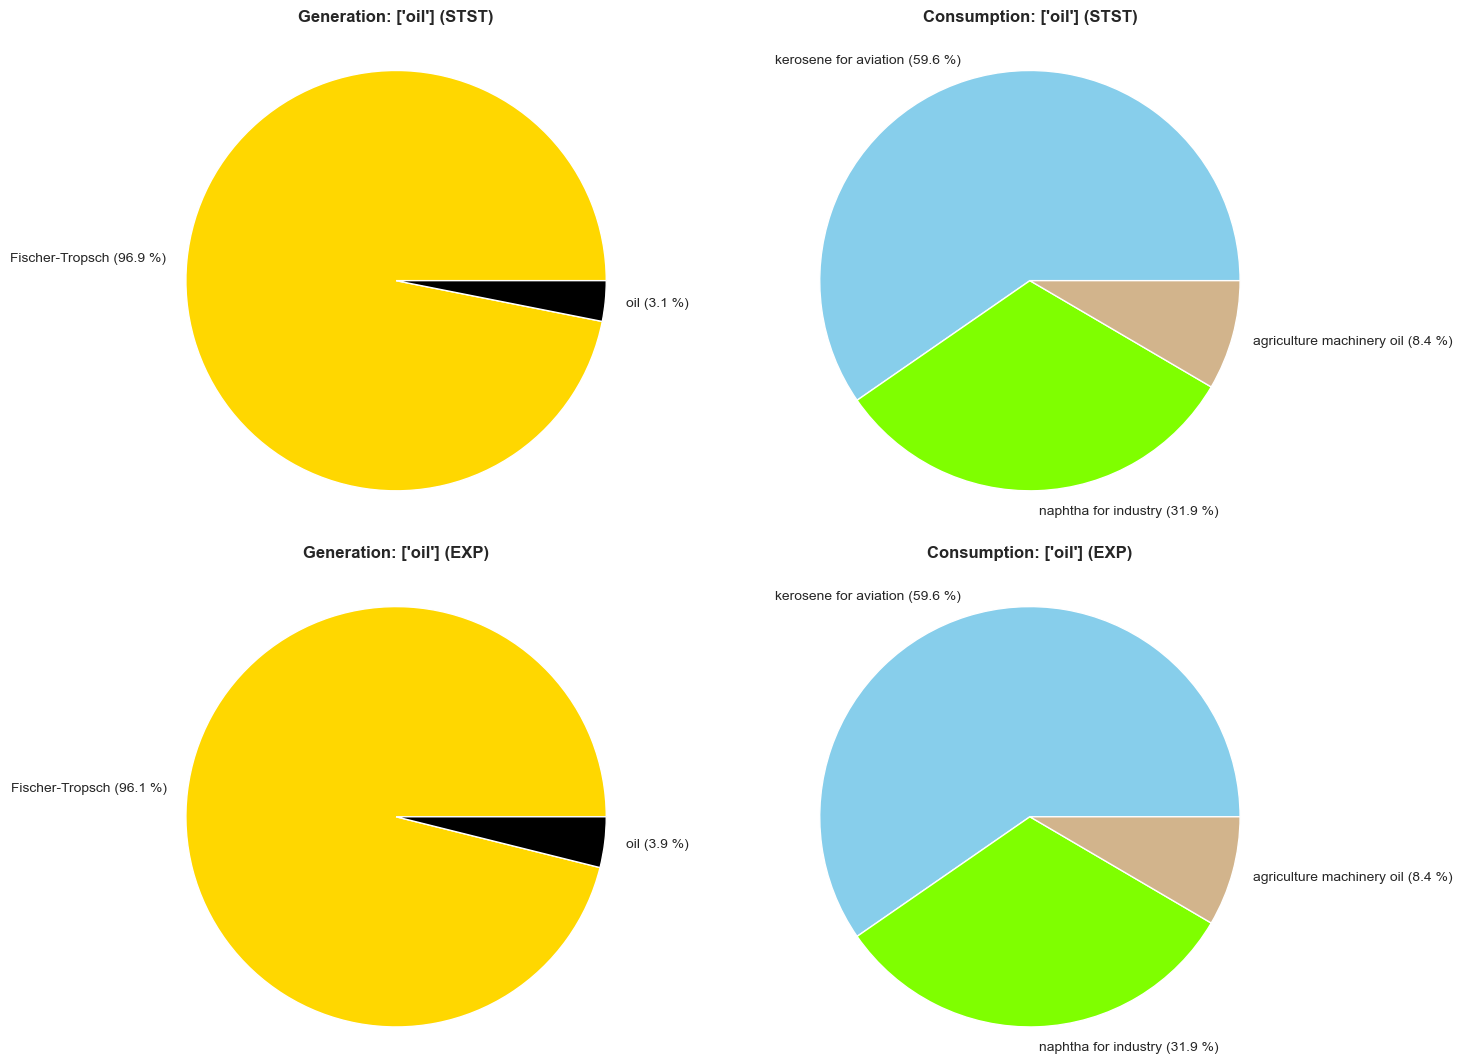

In [13]:
# generation and consumption (oil)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["oil"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, colors=c, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, colors=c, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

fig.savefig(f"{PLOT_DIR}/oil_gen_con.png")

### gas

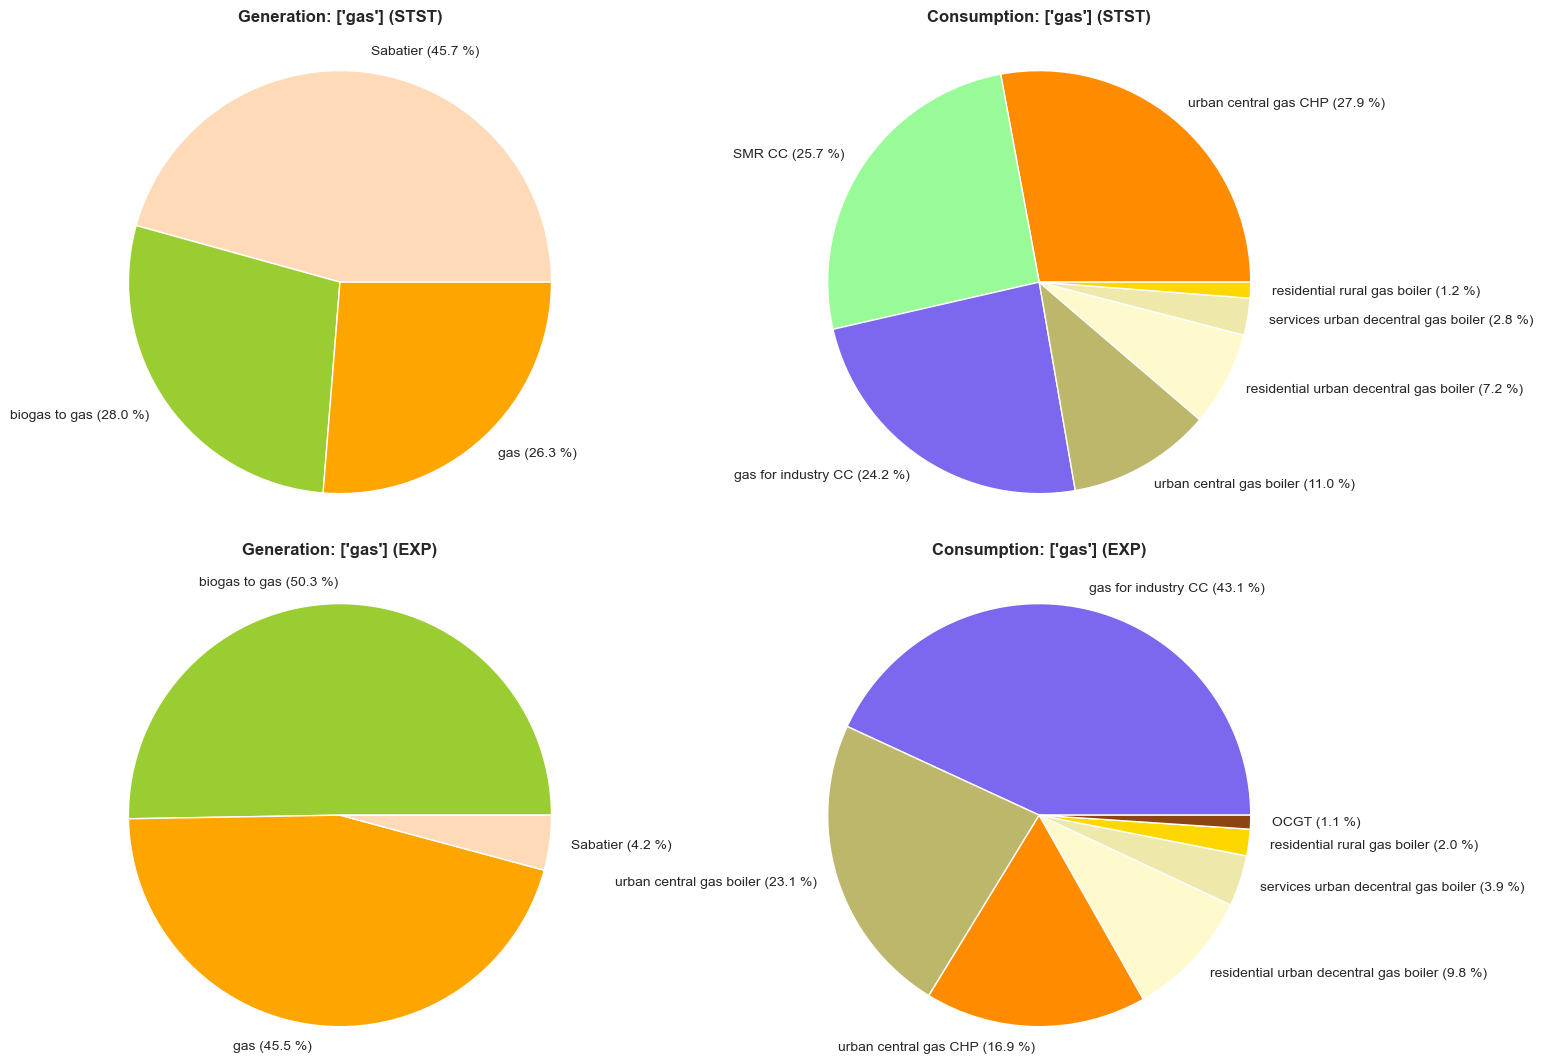

In [14]:
# generation and consumption (gas)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["gas"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, colors=c, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, colors=c, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

fig.savefig(f"{PLOT_DIR}/gas_gen_con.png")

In [15]:
n = exp
carrier = ["gas"]
nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MW to GW
nb = nb.unstack(level=[1]) / 1000

nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

### testing

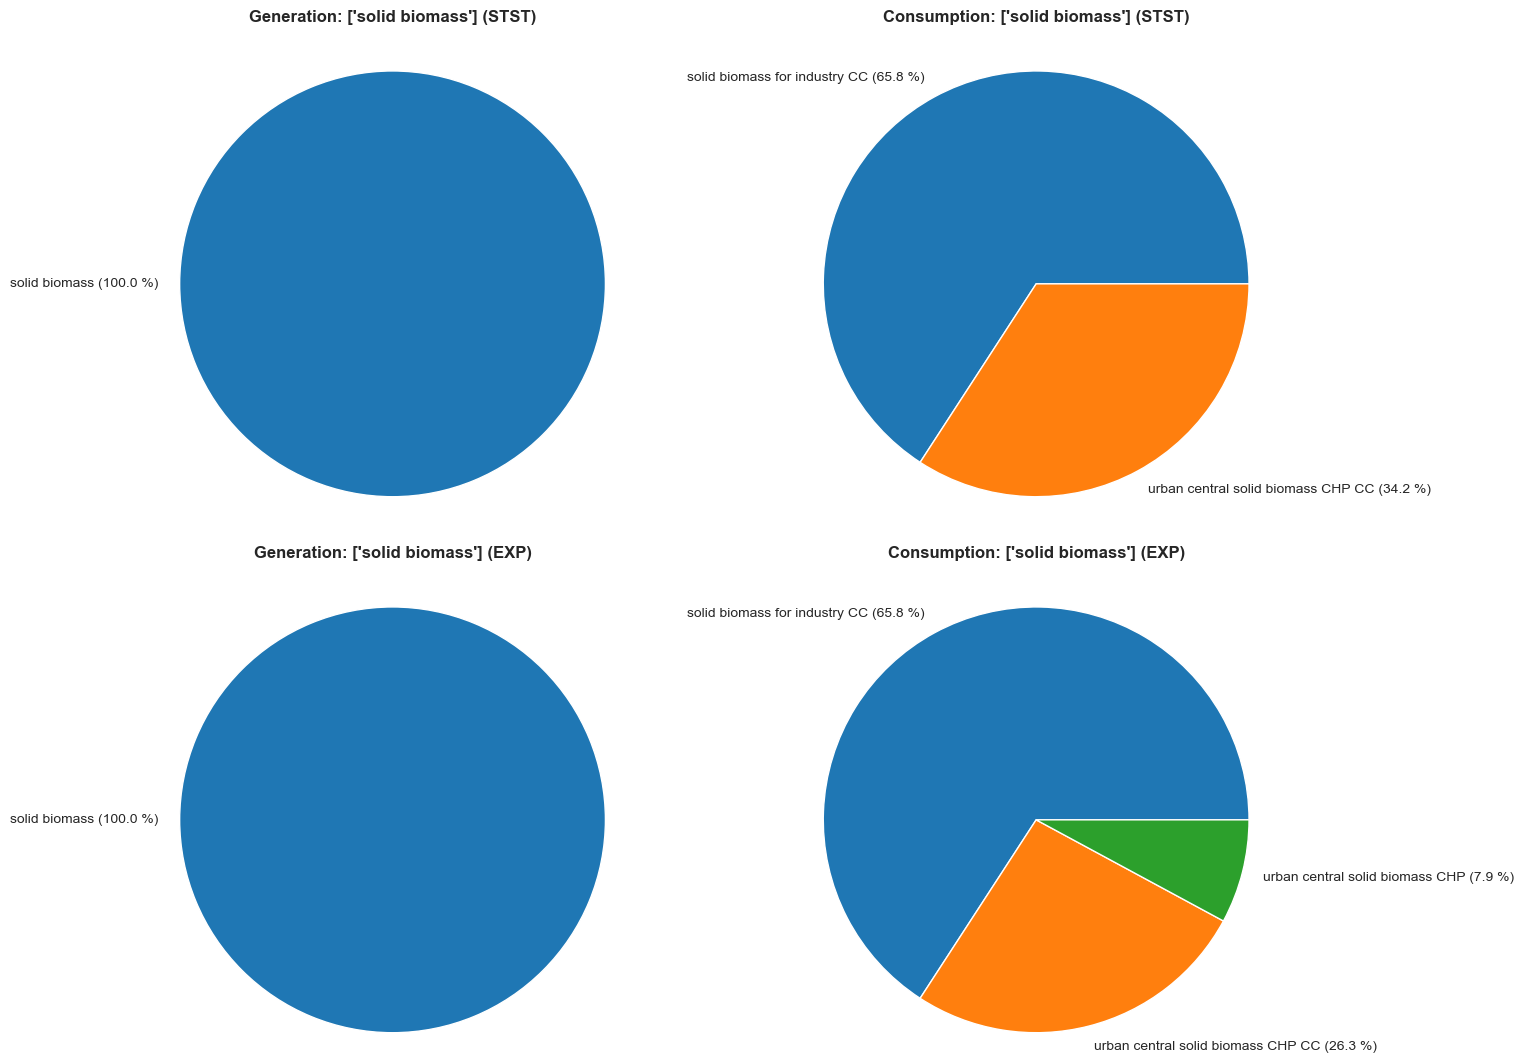

In [16]:
# generation and consumption
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [stst, exp]:

    carrier = ["solid biomass"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==stst:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==exp:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    #c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    #c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg,  startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
#plt.close()
plt.show()

## Sabatier

In [17]:
# gas production
# Sabatier: 563 TWh (STST), 29 TWh (EXP)
c = "Sabatier"

In [18]:
df_stst_ons[f"{c}_gen_gas"]

name
AL0 0   NaN
AT0 0   NaN
AT0 1   NaN
AT0 2   NaN
BA0 0   NaN
         ..
SE3 5   NaN
SE3 6   NaN
SE3 7   NaN
SI0 0   NaN
SK0 0   NaN
Name: Sabatier_gen_gas, Length: 181, dtype: float64

In [19]:
n = stst
n.links[n.links.carrier == "Sabatier"]

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_opt,charger_ratio,type,build_year,p_nom_min,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 Sabatier,AL0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,1500.694974,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AT0 0 Sabatier,AT0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,374.644599,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AT0 1 Sabatier,AT0 1 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,10.428968,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
AT0 2 Sabatier,AT0 2 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,447.356313,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
BA0 0 Sabatier,BA0 0 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,32.769287,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 Sabatier,SE3 5 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,5.913029,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
SE3 6 Sabatier,SE3 6 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,0.907807,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN
SE3 7 Sabatier,SE3 7 H2,EU gas,Sabatier,,0.0,0.0,,NaN,NaN,0.0,...,2.638119,NaN,,0,0.0,0.0,1.0,1.0,NaN,NaN


## Fischer-Tropsch


In [20]:
c = "Fischer-Tropsch"
n = stst
carrier = ["oil"]
carrier = ['residential rural heat',
            'services rural heat',
            'residential urban decentral heat',
            'services urban decentral heat',
            'urban central heat']

nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MW to GW
nb = nb.unstack(level=[1]) / 1000

nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
# exclude all shares smaller than 1 %
nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

In [21]:
nb_pos / 1e3

# Oil production: 995 TWh (STST), 986 TWh (EXP)
# total heat production: 355 TWh (STST), 352 TWh (EXP)

carrier
urban central air heat pump                     636.187172
residential urban decentral air heat pump       504.181469
residential rural ground heat pump              468.286691
services rural ground heat pump                 365.918174
Fischer-Tropsch                                 355.249533
urban central water tanks discharger            302.451510
urban central solid biomass CHP CC              296.570120
services urban decentral air heat pump          201.162255
urban central gas CHP                           139.465576
urban central gas boiler                        139.360398
urban central resistive heater                  128.680866
residential urban decentral gas boiler           86.419404
urban central solar thermal                      49.520527
residential urban decentral resistive heater     38.601290
dtype: float64

## Loads

In [22]:
c_loads = n.loads.carrier.unique()
df_loads = pd.DataFrame(index = c_loads, columns=["overall_load"])
df_loads.index[df_loads.index.str.contains("heat")]

Index(['residential rural heat', 'services rural heat',
       'residential urban decentral heat', 'services urban decentral heat',
       'urban central heat', 'low-temperature heat for industry',
       'agriculture heat'],
      dtype='object')

In [23]:
for c_l in c_loads:
    index = n.loads[n.loads.carrier == c_l].index
    df_loads.loc[c_l , "overall_load"] = n.loads_t.p.loc[: , index].sum().sum() / 1e6 * 3 # TWh

In [24]:
df_loads.sort_values(by="overall_load", ascending=False)

,overall_load
electricity,1720.767554
industry electricity,1702.52
urban central heat,1517.120729
land transport EV,779.898679
solid biomass for industry,702.4
residential urban decentral heat,628.402898
kerosene for aviation,612.245731
H2 for shipping,502.844346
residential rural heat,498.690501
naphtha for industry,327.78
